# **Import Libraries & Data Loading**

In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re # if u want to learn regex [https://regex101.com/]
import string
import random # Random number generators - Library for generating random numbers, selecting random elements, shuffling sequences, etc.
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.set_option("display.max_columns", None)
# pd.set_option("display.max_row", None)

In [37]:
def check_duplicates(dataframe, kolom = None):
    print("Duplicate Values (Top 10):")
    duplicate_values = dataframe[dataframe.duplicated(subset = kolom)]
    print(f"Number of Duplicate Rows: {duplicate_values.shape[0]}")
    display(duplicate_values.head(10))

def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

# **Load Data**

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
mainPath = "/content/drive/MyDrive/Colab Notebooks/9. DBS Foundation x Dicoding Kelas Menengah 2024"
folder_path_all_data = "/content/drive/MyDrive/Colab Notebooks/9. DBS Foundation x Dicoding Kelas Menengah 2024/Start Dari 0 Lagi"

additionalPath = os.path.join(mainPath, "Additional Data")
modelPath = os.path.join(folder_path_all_data, "/Trained Model")

In [40]:
train = pd.read_csv(folder_path_all_data + "/Data After Labeling/train_based_on_bert_transformers.csv")

# Lexicon dan stopword additional dimana beberapa aku buat manual berdasarkan data dan sisanya didaptkan dari github.
lexicon_corpus = pd.read_excel(additionalPath + "/colloquial-indonesian-lexicon.xlsx", sheet_name="Clean-Colloquial-Lexicon")
stopword_corpus = pd.read_excel(additionalPath + "/Stopword.xlsx")

In [41]:
train.columns

Index(['full_text', 'label based on roBERTa Model', 'sentiment score'], dtype='object')

In [42]:
train.shape

(26894, 3)

In [43]:
train["label based on roBERTa Model"].value_counts()

label based on roBERTa Model
neutral     12789
negative     8425
positive     5680
Name: count, dtype: int64

In [44]:
def read_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        stopwords = file.read().splitlines()
    return stopwords

# Path ke file stopwords lokal
file_path_stopword_1 = additionalPath + "/stopwords-id.txt"
file_path_stopword_2 = additionalPath + "/id.stopwords.02.01.2016.txt"

# Membaca stopwords dari kedua file
stopwords1 = read_stopwords(file_path_stopword_1)
stopwords2 = read_stopwords(file_path_stopword_2)

# Menggabungkan kedua daftar stopwords dan menghapus duplikasi
stopwords_again = set(stopwords1).union(set(stopwords2))

# **Simple Explore the Data**

In [ ]:
check_duplicates(train, "full_text")
# drop duplicate entries considering all columns
train = train.drop_duplicates(subset="full_text")

Duplicate Values (Top 10):
Number of Duplicate Rows: 0


,full_text,label based on roBERTa Model,sentiment score


In [ ]:
missing_data(train)

,Total,Percent
full_text,0,0.0
label based on roBERTa Model,0,0.0
sentiment score,0,0.0


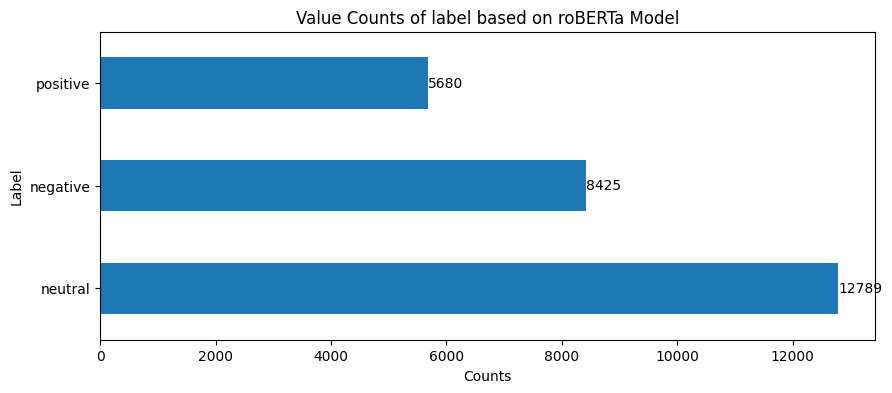

In [ ]:
label_counts = train["label based on roBERTa Model"].value_counts()

# Plot barh
ax = label_counts.plot(kind='barh', figsize=(10, 4))

# Tambahkan label di setiap bar
for i in ax.patches:
    ax.text(i.get_width() + 0.1, i.get_y() + i.get_height()/2, str(i.get_width()),
            fontsize=10, color='black', verticalalignment='center')

# Berikan judul dan label sumbu
plt.title('Value Counts of label based on roBERTa Model')
plt.xlabel('Counts')
plt.ylabel('Label')

# Tampilkan plot
plt.show()

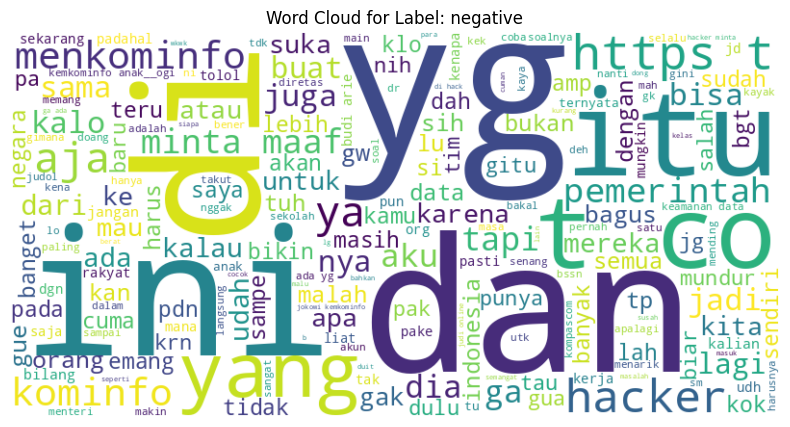

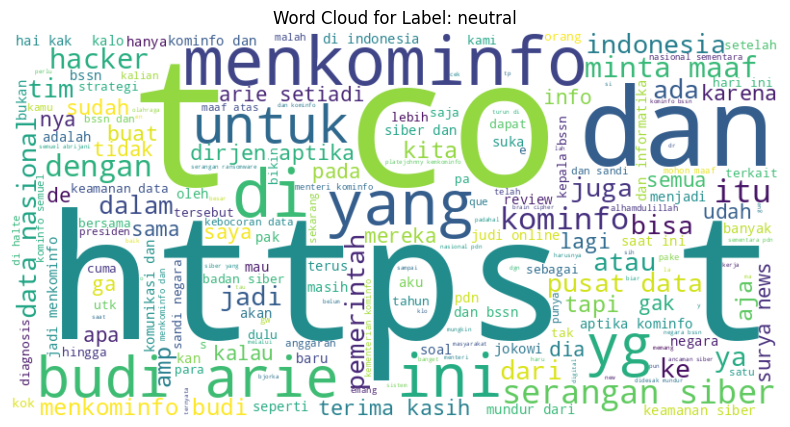

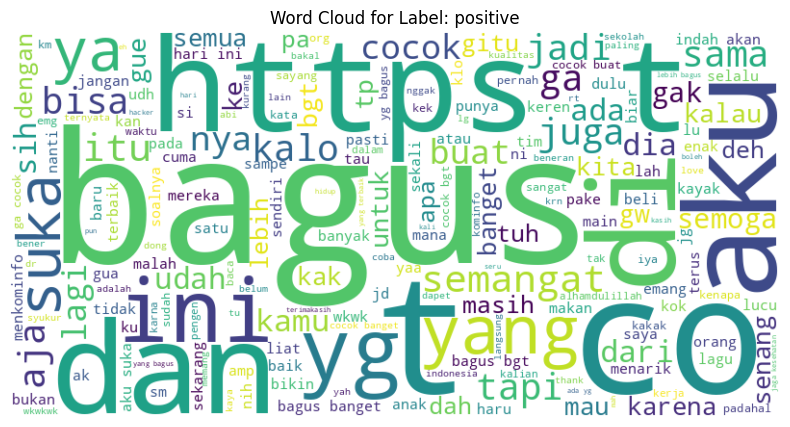

In [ ]:
labels = train["label based on roBERTa Model"].unique()
texts_by_label = {label: " ".join(train[train["label based on roBERTa Model"] == label]["full_text"].str.lower().tolist()) for label in labels}

for label, text in texts_by_label.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label: {label}')
    plt.axis('off')
    plt.show()

# Splitting Data for Model Inference Purposes


In [ ]:
train.rename(columns={"label based on roBERTa Model": "label"}, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split

# Pisahkan data menjadi data latih dan data uji
train, test = train_test_split(train, test_size=0.1, random_state=42, stratify=train.label)

# Menampilkan jumlah data latih dan data uji
print(f'Jumlah data latih: {train.shape[0]}')
print(f'Jumlah data uji: {test.shape[0]}')

Jumlah data latih: 24204
Jumlah data uji: 2690


In [ ]:
print(train.label.value_counts(),"\n")
print(test.label.value_counts())

label
neutral     11510
negative     7582
positive     5112
Name: count, dtype: int64 

label
neutral     1279
negative     843
positive     568
Name: count, dtype: int64


In [ ]:
'''
Ini adalah test data untuk nanti di gunakan testing prediction model pada model Inference
nb: data test ini berasal dari train
'''
test.to_csv(folder_path_all_data + "/Data After Labeling/test model inference.csv", index=False)

In [ ]:
train.to_csv(folder_path_all_data + "/Data After Labeling/train_final_after_splitting.csv", index=False)

# Text Processing

In [ ]:
train = pd.read_csv(folder_path_all_data + "/Data After Labeling/train_final_after_splitting.csv")

Refrensi Stopword Corpus:
- https://github.com/stopwords-iso/stopwords-id/blob/master/stopwords-id.txt
- https://github.com/masdevid/ID-Stopwords/blob/master/id.stopwords.02.01.2016.txt

In [ ]:
!pip install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
import nltk # Natural Language Toolkit - Library for natural language processing (NLP) tasks such as tokenization, stemming, tagging, parsing, and more.
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm import tqdm # A Fast, Extensible Progress Bar - Library for creating progress bars to monitor the progress of iterations or tasks.
from nltk.stem import WordNetLemmatizer, PorterStemmer

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
nltk.download(['punkt','stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    # Mendapatkan stopwords dari Sastrawi
    global listStopwords
    factory = StopWordRemoverFactory()
    sastrawi_stopwords = factory.get_stop_words()
    listStopwords = set(stopwords.words('indonesian')) # Stopword Indo NLTK
    listStopwords1 = set(stopwords.words('english')) # Stopword English NLTK
    listStopwords.update(listStopwords1)
    listStopwords.update(sastrawi_stopwords)
    listStopwords.update(stopword_corpus) # Stopword by me
    listStopwords.update(stopwords_again) # Stopword I get from Github
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    listStopwords = set(listStopwords)


    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
def fix_slangwords(text, lexicon_corpus = lexicon_corpus):
    # Menghapus duplikasi pada lexicon_corpus
    lexicon_corpus.drop_duplicates(subset=['slang'], inplace=True)

    # Menghapus nilai NaN di dalam corpus lexicon
    lexicon_corpus = lexicon_corpus.dropna(subset=['formal'])

    # Membuat pasangan slang dan formal
    slang_formal_pairs = list(zip(lexicon_corpus['slang'], lexicon_corpus['formal']))

    # Fungsi untuk mengganti kata-kata slang dengan kata formal
    def replace_slang(text, slang_formal_pairs):
        for slang, formal in slang_formal_pairs:
            text = re.sub(r'\b{}\b'.format(re.escape(slang)), formal, text)
        return text

    # Lowercasing
    text = text.lower()
    # Mengganti kata-kata slang dengan kata formal
    text = replace_slang(text, slang_formal_pairs)

    return text

In [ ]:
# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
train['text_casefoldingText'] = train['full_text'].apply(casefoldingText)

In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
train['text_clean'] = train['text_casefoldingText'].apply(cleaningText)

In [ ]:
# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
train['text_slangwords'] = train['text_clean'].apply(fix_slangwords)

In [ ]:
# # train.to_csv(folder_path_all_data + "/Data After Labeling/BelumSelesai.csv", index=False)
# train = pd.read_csv(folder_path_all_data + "/Data After Labeling/BelumSelesai.csv")
train = train.dropna(subset = "text_slangwords")

In [ ]:
# Mengganti kata-kata tidak baku kedalam kata bakunya dan menyimpannya di 'text_stemmings'
train['text_stemmings'] = train['text_slangwords'].apply(stemmingText)

In [ ]:
# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
train['text_tokenizingText'] = train['text_stemmings'].apply(tokenizingText)

In [ ]:
# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
train['text_stopword'] = train['text_tokenizingText'].apply(filteringText)

In [ ]:
# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
train['text_akhir'] = train['text_stopword'].apply(toSentence)

In [ ]:
train.head()

,full_text,label,sentiment score,text_casefoldingText,text_clean,text_slangwords,text_stemmings,text_tokenizingText,text_stopword,text_akhir
0,FAIRPLAY MANAGEMENT PRESENT COME FIGHT AND WI...,neutral,0.983584,fairplay management present come fight and wi...,fairplay management present come fight and win...,fairplay manajemen present datang fight dan wi...,fairplay manajemen present datang fight dan wi...,"[fairplay, manajemen, present, datang, fight, ...","[fairplay, manajemen, present, fight, win, sal...",fairplay manajemen present fight win salam ola...
1,Kesaksian seorang hacker Situs-situs pemerinta...,negative,0.651368,kesaksian seorang hacker situs-situs pemerinta...,kesaksian seorang hacker situssitus pemerintah...,kesaksian seorang peretas situssitus pemerinta...,saksi orang retas situssitus perintah justru y...,"[saksi, orang, retas, situssitus, perintah, ju...","[saksi, orang, retas, situssitus, perintah, le...",saksi orang retas situssitus perintah lemah aj...
2,Nemu akun preloved disini dan gua cek barangny...,neutral,0.851601,nemu akun preloved disini dan gua cek barangny...,nemu akun preloved disini dan gua cek barangny...,temu akun preloved disini dan saya periksa bar...,temu akun preloved sini dan saya periksa baran...,"[temu, akun, preloved, sini, dan, saya, periks...","[temu, akun, preloved, periksa, barang, bagus,...",temu akun preloved periksa barang bagus iseng ...
3,Udah waktunya Indonesia melakukan revolusi inf...,neutral,0.997197,udah waktunya indonesia melakukan revolusi inf...,udah waktunya indonesia melakukan revolusi inf...,sudah waktunya indonesia melakukan revolusi in...,sudah waktu indonesia laku revolusi infrastruk...,"[sudah, waktu, indonesia, laku, revolusi, infr...","[indonesia, laku, revolusi, infrastruktur, bid...",indonesia laku revolusi infrastruktur bidang t...
4,haloooo gaissss!!! yg mau joki tugas buat prop...,neutral,0.964209,haloooo gaissss!!! yg mau joki tugas buat prop...,haloooo gaissss yg mau joki tugas buat proposa...,haloooo gaissss yang mau joki tugas buat propo...,haloooo gaissss yang mau joki tugas buat propo...,"[haloooo, gaissss, yang, mau, joki, tugas, bua...","[haloooo, gaissss, joki, tugas, proposal, pene...",haloooo gaissss joki tugas proposal penelitian...


In [ ]:
train.isnull().sum()

full_text               0
label                   0
sentiment score         0
text_casefoldingText    0
text_clean              0
text_slangwords         0
text_stemmings          0
text_tokenizingText     0
text_stopword           0
text_akhir              0
dtype: int64

In [49]:
# train.to_csv(folder_path_all_data + "/Data After Labeling/train_after_processing.csv", index=False)

In [55]:
train.label.value_counts()

label
neutral     11503
negative     7582
positive     5112
Name: count, dtype: int64

## Data After Processing

[Click here for a detailed explanation about the data](https://docs.google.com/document/d/1tWmKG9GRu-7CJcshRx9SlGiiDI4FYdgdQZzR-EVa934/edit?usp=sharing)

In [53]:
train = pd.read_csv(folder_path_all_data + "/Data After Labeling/train_after_processing.csv")

In [ ]:
# Memeriksa apakah "ya" ada di dalam listStopwords
word_to_check = "ya"
is_in_stopwords = word_to_check in listStopwords

print(f'"{word_to_check}" is in the stopwords list: {is_in_stopwords}')

# Kriteria Utama:
1. [x] Data merupakan hasil scraping secara mandiri 3.000 sampel
2. [x] Melakukan tahapan ekstraksi fitur dan pelabelan data
3. [x] Menggunakan algoritma pelatihan machine learning
4. [x] Akurasi testing set yang didapatkan untuk setiap skema pelatihan minimal harus mencapai 85%

# Saran untuk mendapatkan nilai tinggi:
1. [x] Menggunakan algoritma deep learning di luar dari contoh latihan
2. [x] Akurasi pada training set dan testing set di atas 92%
3. [x] Dataset memiliki minimal tiga kelas
4. [x] Memiliki jumlah data minimal 10.000 sampel data
5. [x] Melakukan 3 percobaan skema pelatihan yang berbeda; *Variasi* algoritma pelatihan,* Variasi* metode ekstraksi fitur, *Variasi *metode pelabelan, *Variasi* pembagian data dengan memilih minimal 2 kombinasi
6. [x] Melakukan inference atau testing dalam file .ipynb atau .py yang menghasilkan output berupa kelas kategorikal (contoh: negatif, netral, dan positif)

# My Skenario:

1. **Skenario 1**: Jumlah data train awal adalah 24183, lalu setelah itu di imbalanced class bersisa **12750 data**, dengan jumlah train dan test adalah 10200 dan 2550 (**80%:20%**) Menggunakan Feature Extraction dari bert Transformers "mdhugol/indonesia-bert-sentiment-classification" dan TF-IDF dan terbaik ada di Transformers Feature Extraction dan model Machine Learning Gaussian Naive Bayes dengan akurasi test sebesar **0.9862745098039216** (98.6%).

2. **Skenario 2**: Menggunakan Deep Learning dengan Algoritma Long short-term memory (LSTM) dan feature yang digunakan adalah feature extraction dari Auto_Tokenizer "mdhugol/indonesia-bert-sentiment-classification". Untuk Dataset total adalah **12750**, dan Rasio data train dan test adalah 10837 dan 1913 (**85%:15%**). Pada skenario ini didapatkan akurasi sebesar **0.9882352948188782** (98.8%).
  
3. **Skenario 3**: Menggunakan Transfer Learning/fine-tune Model "mdhugol/indonesia-bert-sentiment-classification" dari huggingface.co dan Jumlah total data yang sama dengan Skenario 1 yaitu **12750**, namun Rasio data menjadi train dan test (**90%:10%**) sebesar 11475 dan 1275. Untuk feature extraction menggunakan auto_tokenizer dari model sebagai representasi numerik. Pada scenario ini hasil akurasi test fine-tune Model sebesar **0.9662745098039216** (96.6%).

# ***SKENARIO - 1***
---

In [56]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, average_precision_score

import time

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

## Split X and y

In [57]:
train.isnull().sum()
train = train.dropna(subset = "text_akhir")

In [58]:
neg = train[train["label"] == "negative"]
pos = train[train["label"] == "positive"]
neu = train[train["label"] == "neutral"]

In [59]:
print(f' Total data hasil scraping Twitter adalah sebanyak {train.shape[0]} data', "\n")
print(f' Total data negative adalah sebanyak: {neg.shape[0]} data')
print(f' Total data neutral adalah sebanyak: {neu.shape[0]} data')
print(f' Total data positive adalah sebanyak: {pos.shape[0]} data')

 Total data hasil scraping Twitter adalah sebanyak 24183 data 

 Total data negative adalah sebanyak: 7580 data
 Total data neutral adalah sebanyak: 11498 data
 Total data positive adalah sebanyak: 5105 data


In [60]:
'''Jadi karena data imbalanced, maka akan di balancing'''

'Jadi karena data imbalanced, maka akan di balancing'

In [61]:
neu = neu.sort_values(by = "sentiment score", ascending = False).head(4250)
neg = neg.sort_values(by = "sentiment score", ascending = False).head(4250)
pos = pos.sort_values(by = "sentiment score", ascending = False).head(4250)

In [62]:
train = pd.concat([neg, pos, neu], ignore_index=True)

In [63]:
print(f' Total data hasil scraping Twitter adalah sebanyak {train.shape[0]} data', "\n")
print(f' Total data negative adalah sebanyak: {neg.shape[0]} data')
print(f' Total data neutral adalah sebanyak: {neu.shape[0]} data')
print(f' Total data positive adalah sebanyak: {pos.shape[0]} data')

 Total data hasil scraping Twitter adalah sebanyak 12750 data 

 Total data negative adalah sebanyak: 4250 data
 Total data neutral adalah sebanyak: 4250 data
 Total data positive adalah sebanyak: 4250 data


In [64]:
# Pisahkan data menjadi fitur (tweet) dan label (sentimen)
X = train['text_akhir']
y = train['label']

## Feature Extraction

### BERT Transformer

https://www.kaggle.com/code/sujithmandala/simple-feature-extractor-bert-model#Simple-Feature-Extractor-using-BERT-Model

In [ ]:
!pip install transformers
from transformers import BertModel, BertTokenizer
import torch

In [ ]:
# Load the pre-trained BERT model and tokenizer
model = BertModel.from_pretrained('mdhugol/indonesia-bert-sentiment-classification', output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('mdhugol/indonesia-bert-sentiment-classification')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Define a function to extract features for each transaction
def extract_features(text):
    # Tokenize the text
    input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
    # Get the hidden states for each token
    with torch.no_grad():
        outputs = model(input_ids)
        hidden_states = outputs[2]
    # Concatenate the last 4 hidden states
    token_vecs = []
    for layer in range(-4, 0):
        token_vecs.append(hidden_states[layer][0])
    # Calculate the mean of the last 4 hidden states
    features = []
    for token in token_vecs:
        features.append(torch.mean(token, dim=0))
    # Return the features as a tensor
    return torch.stack(features)

In [ ]:
# Extract features for each transaction
features = []
for i in range(len(train)):
    features.append(extract_features(train.iloc[i]["text_akhir"]))
# Concatenate the features and convert to a numpy array
features = torch.cat(features).numpy()

In [ ]:
features

array([[ 0.3755689 , -0.06602324,  0.12716529, ...,  0.83326817,
        -1.692582  , -0.40330908],
       [ 0.42541724,  0.13478225,  0.48638007, ...,  0.7742595 ,
        -2.1160605 , -0.24978529],
       [ 0.59465706,  0.2280338 ,  1.0263653 , ...,  0.58320737,
        -1.4966241 , -0.29138798],
       ...,
       [-0.2219699 , -0.9398893 ,  1.2294312 , ...,  0.12884477,
        -0.98098874,  0.09818135],
       [-0.19196199, -0.74700516,  1.6124247 , ..., -0.05780453,
        -0.59349734, -0.10028489],
       [ 0.19314638, -0.42263752,  1.3746259 , ..., -0.57999235,
         0.10886   ,  0.12552407]], dtype=float32)

In [65]:
# # Save the features as a .npy file
# np.save(folder_path_all_data + "/Data After Labeling/[Untuk ML]train_bert_transformer_features.npy", features)

# load features from a .npy file
features = np.load(folder_path_all_data + "/Data After Labeling/[Untuk ML]train_bert_transformer_features.npy")

In [66]:
labels = train['label'].values
labels

array(['negative', 'negative', 'negative', ..., 'neutral', 'neutral',
       'neutral'], dtype=object)

In [67]:
print(features.shape)
print(labels.shape)

(51000, 768)
(12750,)


In [68]:
# features is a 2D numpy array of size 40632x768
# labels is a 1D numpy array of size 10158
# reshape the feature array to size 10158x(768*3)

features_reshaped = features.reshape((12750, -1))

# concatenate the feature array with the label array horizontally
dataset_bert_extraction = np.hstack((features_reshaped, labels.reshape((-1, 1))))

# dataset is a 2D numpy array of size 1000x(4000*768+1)

In [69]:
display(features_reshaped.shape)
display(dataset_bert_extraction.shape)

(12750, 3072)

(12750, 3073)

## Split Xtrain, Ytrain, Xtest, Ytest

In [70]:
# Memisahkan fitur dan label
X_bert = dataset_bert_extraction[:, :-1]  # Semua kolom kecuali kolom terakhir
y_bert = dataset_bert_extraction[:, -1]   # Kolom terakhir sebagai label

# Membagi data dengan stratifikasi
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    X_bert, y_bert,
    test_size=0.2,
    random_state=7,
    stratify=y_bert
)

# Menggabungkan kembali fitur dan label menjadi satu array
bert_train_data = np.hstack((X_train_bert, y_train_bert.reshape(-1, 1)))
bert_test_data = np.hstack((X_test_bert, y_test_bert.reshape(-1, 1)))

In [71]:
bert_train_data.shape, bert_test_data.shape

((10200, 3073), (2550, 3073))

In [72]:
Counter(y_train_bert), Counter(y_test_bert)

(Counter({'neutral': 3400, 'negative': 3400, 'positive': 3400}),
 Counter({'positive': 850, 'negative': 850, 'neutral': 850}))

## Modelling & Evaluation - Base Model

In [73]:
from sklearn.preprocessing import MinMaxScaler

In [80]:
# Normalisasi data
scaler = MinMaxScaler()

# Hanya untuk MultinomialNB, karena model lain dapat menangani nilai negatif
X_train_bert_normalized = scaler.fit_transform(X_train_bert)
X_test_bert_normalized = scaler.transform(X_test_bert)

# Inisialisasi model
models = {
    'Gaussian Naive Bayes': GaussianNB(),
}

In [81]:
for name, model in models.items():

    # Mengubah data ke dalam bentuk array untuk GaussianNB
    if name == 'Multinomial Naive Bayes':
        # Gunakan data yang sudah dinormalisasi untuk MultinomialNB
        X_train_data = X_train_bert_normalized
        X_test_data = X_test_bert_normalized
    else:
        X_train_data = X_train_bert
        X_test_data = X_test_bert

    # Melatih model
    if name in ['LightGBM']:
        model.fit(X_train_data, y_train_encoded)  # Gunakan label yang telah di-encode
    else:
        model.fit(X_train_data, y_train_bert)

    # Prediksi sentimen pada data pelatihan dan data uji
    if name in ['XGBoost', 'LightGBM']:
        y_pred_train = model.predict(X_train_data)
        y_pred_test = model.predict(X_test_data)
        y_pred_train = label_encoder.inverse_transform(y_pred_train)
        y_pred_test = label_encoder.inverse_transform(y_pred_test)
    else:
        y_pred_train = model.predict(X_train_data)
        y_pred_test = model.predict(X_test_data)

    # Evaluasi akurasi model
    accuracy_train = accuracy_score(y_train_bert, y_pred_train)
    accuracy_test = accuracy_score(y_test_bert, y_pred_test)

    # Evaluasi data test
    precision = precision_score(y_test_bert, y_pred_test, average='weighted')  # 'weighted' untuk multikelas
    recall = recall_score(y_test_bert, y_pred_test, average='weighted')
    f1 = f1_score(y_test_bert, y_pred_test, average='weighted')
    conf_matrix = confusion_matrix(y_test_bert, y_pred_test)

    # Evaluasi model
    print(f'{name} - accuracy_train: {accuracy_train:.5f}')
    print(f'{name} - accuracy_test: {accuracy_test:.5f}\n')
    print("Classification Report:\n", classification_report(y_test_bert, y_pred_test))

    print("Evaluasi Model:")
    print("------------------")
    print(f"Precision         : {precision:.5f}")
    print(f"Recall            : {recall:.5f}")
    print(f"F1-Score          : {f1:.5f}")
    print("\nConfusion Matrix:")
    print(conf_matrix, "\n")
    print("-" * 35, "\n")

Gaussian Naive Bayes - accuracy_train: 0.98716
Gaussian Naive Bayes - accuracy_test: 0.98627

Classification Report:
               precision    recall  f1-score   support

    negative       0.99      0.98      0.98       850
     neutral       0.99      0.99      0.99       850
    positive       0.99      0.98      0.99       850

    accuracy                           0.99      2550
   macro avg       0.99      0.99      0.99      2550
weighted avg       0.99      0.99      0.99      2550

Evaluasi Model:
------------------
Precision         : 0.98628
Recall            : 0.98627
F1-Score          : 0.98627

Confusion Matrix:
[[833   8   9]
 [  2 845   3]
 [  9   4 837]] 

----------------------------------- 



In [82]:
# Munculkan panduan label setelah encoding
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print("Panduan Label setelah Encoding:")
for key, value in label_mapping.items():
    print(f"Encoded {key} untuk label {value}")

Panduan Label setelah Encoding:
Encoded 0 untuk label negative
Encoded 1 untuk label neutral
Encoded 2 untuk label positive


## Saving Model and Prove 92% ++ Test ACC

In [ ]:
import pickle

Untuk BERT Transformer Extraction, terbaik ada di Random Forest

In [ ]:
# Menyimpan model ke file
with open(folder_path_all_data + "/Trained Model/" + '1. BERT_Gaussian_Naive_Bayes_model_[0.9862745098039216].pkl', 'wb') as file:
    pickle.dump(models['Gaussian Naive Bayes'], file)

In [ ]:
# Memuat kembali model dari file
with open(folder_path_all_data + "/Trained Model/" + '1. BERT_Gaussian_Naive_Bayes_model_[0.9862745098039216].pkl', 'rb') as file:
    loaded_model2 = pickle.load(file)

In [ ]:
y_pred_test_bert = loaded_model2.predict(X_test_data)

In [ ]:
# Evaluasi akurasi model
accuracy_test = accuracy_score(y_test_bert, y_pred_test_bert)

In [ ]:
accuracy_test # Lulus Persyaratannya

0.9862745098039216

## ***Model Indeference***
---

In [ ]:
test = pd.read_csv(folder_path_all_data + "/Data After Labeling/test model inference [After Processing].csv")

### Text Processing

In [ ]:
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    # Mendapatkan stopwords dari Sastrawi
    global listStopwords
    factory = StopWordRemoverFactory()
    sastrawi_stopwords = factory.get_stop_words()
    listStopwords = set(stopwords.words('indonesian')) # Stopword Indo NLTK
    listStopwords1 = set(stopwords.words('english')) # Stopword English NLTK
    listStopwords.update(listStopwords1)
    listStopwords.update(sastrawi_stopwords)
    listStopwords.update(stopword_corpus) # Stopword by me
    listStopwords.update(stopwords_again) # Stopword I get from Github
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    listStopwords = set(listStopwords)


    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

def fix_slangwords(text, lexicon_corpus = lexicon_corpus):
    # Menghapus duplikasi pada lexicon_corpus
    lexicon_corpus.drop_duplicates(subset=['slang'], inplace=True)

    # Menghapus nilai NaN di dalam corpus lexicon
    lexicon_corpus = lexicon_corpus.dropna(subset=['formal'])

    # Membuat pasangan slang dan formal
    slang_formal_pairs = list(zip(lexicon_corpus['slang'], lexicon_corpus['formal']))

    # Fungsi untuk mengganti kata-kata slang dengan kata formal
    def replace_slang(text, slang_formal_pairs):
        for slang, formal in slang_formal_pairs:
            text = re.sub(r'\b{}\b'.format(re.escape(slang)), formal, text)
        return text

    # Lowercasing
    text = text.lower()
    # Mengganti kata-kata slang dengan kata formal
    text = replace_slang(text, slang_formal_pairs)

    return text

In [ ]:
print(test.shape,"\n")
test["label"].value_counts()

(2690, 3) 



label
neutral     1279
negative     843
positive     568
Name: count, dtype: int64

In [ ]:
# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
test['text_casefoldingText'] = test['full_text'].apply(casefoldingText)

In [ ]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
test['text_clean'] = test['text_casefoldingText'].apply(cleaningText)

In [ ]:
# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
test['text_slangwords'] = test['text_clean'].apply(fix_slangwords)

In [ ]:
# Mengganti kata-kata tidak baku kedalam kata bakunya dan menyimpannya di 'text_stemmings'
test['text_stemmings'] = test['text_slangwords'].apply(stemmingText)

In [ ]:
# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
test['text_tokenizingText'] = test['text_stemmings'].apply(tokenizingText)

In [ ]:
# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
test['text_stopword'] = test['text_tokenizingText'].apply(filteringText)

In [ ]:
# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
test['text_akhir'] = test['text_stopword'].apply(toSentence)

In [ ]:
# test.to_csv(folder_path_all_data + "/Data After Labeling/test model inference [After Processing].csv")

In [ ]:
test = pd.read_csv(folder_path_all_data + "/Data After Labeling/test model inference [After Processing].csv")

In [ ]:
test.isnull().sum()

full_text               0
label                   0
sentiment score         0
text_casefoldingText    0
text_clean              0
text_slangwords         0
text_stemmings          0
text_tokenizingText     0
text_stopword           0
text_akhir              0
dtype: int64

### Feature Extraction with BERT Transformer

In [ ]:
!pip install transformers
from transformers import BertModel, BertTokenizer
import torch

In [ ]:
# Load the pre-trained BERT model and tokenizer
model = BertModel.from_pretrained('mdhugol/indonesia-bert-sentiment-classification', output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('mdhugol/indonesia-bert-sentiment-classification')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Define a function to extract features for each transaction
def extract_features(text):
    # Tokenize the text
    input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
    # Get the hidden states for each token
    with torch.no_grad():
        outputs = model(input_ids)
        hidden_states = outputs[2]
    # Concatenate the last 4 hidden states
    token_vecs = []
    for layer in range(-4, 0):
        token_vecs.append(hidden_states[layer][0])
    # Calculate the mean of the last 4 hidden states
    features = []
    for token in token_vecs:
        features.append(torch.mean(token, dim=0))
    # Return the features as a tensor
    return torch.stack(features)

In [ ]:
# Extract features for each transaction
features = []
for i in range(len(test)):
    features.append(extract_features(test.iloc[i]["text_akhir"]))
# Concatenate the features and convert to a numpy array
features = torch.cat(features).numpy()

In [ ]:
labels = test['label'].values
labels

array(['neutral', 'neutral', 'neutral', ..., 'positive', 'neutral',
       'negative'], dtype=object)

In [ ]:
print(features.shape)
print(labels.shape)

(10760, 768)
(2690,)


In [ ]:
# features is a 2D numpy array of size 10760x768
# labels is a 1D numpy array of size 2690
# reshape the feature array to size 2690x(768*3)

features_reshaped = features.reshape((2690, -1))

# concatenate the feature array with the label array horizontally
dataset_bert_extraction = np.hstack((features_reshaped, labels.reshape((-1, 1))))

# dataset is a 2D numpy array of size 1000x(4000*768+1)

In [ ]:
display(features_reshaped.shape)
display(dataset_bert_extraction.shape)

(2690, 3072)

(2690, 3073)

In [ ]:
# Memisahkan fitur dan label
X_bert = dataset_bert_extraction[:, :-1]  # Semua kolom kecuali kolom terakhir
y_bert = dataset_bert_extraction[:, -1]   # Kolom terakhir sebagai label

In [ ]:
Counter(y_bert)

Counter({'neutral': 1279, 'negative': 843, 'positive': 568})

### Load Model & *Predict*

In [ ]:
import pickle

# Memuat kembali model dari file
with open(folder_path_all_data + "/Trained Model/" + '1. BERT_Gaussian_Naive_Bayes_model_[0.9862745098039216].pkl', 'rb') as file:
    loaded_model1 = pickle.load(file)

In [ ]:
y_pred_bert = loaded_model1.predict(X_bert)

In [ ]:
# Evaluasi akurasi model
accuracy = accuracy_score(y_bert, y_pred_bert)

In [ ]:
accuracy # Akurasi for model Inference

0.8557620817843866

# ***SKENARIO - 2***
---

## **Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mainPath = "/content/drive/MyDrive/Colab Notebooks/9. DBS Foundation x Dicoding Kelas Menengah 2024"
folder_path_all_data = "/content/drive/MyDrive/Colab Notebooks/9. DBS Foundation x Dicoding Kelas Menengah 2024/Start Dari 0 Lagi"

additionalPath = os.path.join(mainPath, "Additional Data")
modelPath = os.path.join(folder_path_all_data, "/Trained Model")

In [ ]:
train = pd.read_csv(folder_path_all_data + "/Data After Labeling/train_after_processing.csv")

In [ ]:
train.isnull().sum()
train = train.dropna(subset = "text_akhir")

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, InputLayer, LSTM, SimpleRNN, GRU, SpatialDropout1D, Bidirectional, GlobalMaxPool1D, BatchNormalization, Dropout, Reshape, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf

import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

import keras
from keras.initializers import Constant
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    precision_score, # Precision score - Metric for evaluating classification models, measuring the ratio of correctly predicted positive observations to the total predicted positives.
    recall_score, # Recall score - Metric for evaluating classification models, measuring the ratio of correctly predicted positive observations to the total actual positives.
    f1_score, # F1 score - Harmonic mean of precision and recall, a metric for evaluating classification models.
    classification_report, # Classification report - Summary of the precision, recall, F1 score, and support for each class in a classification problem.
    accuracy_score, # Accuracy score - Metric for evaluating classification models, measuring the proportion of correct predictions to the total number of predictions.
    balanced_accuracy_score
)

## Exploratory Data Analysis

In [ ]:
train['text_len'] = [len(text.split()) for text in train.text_akhir]

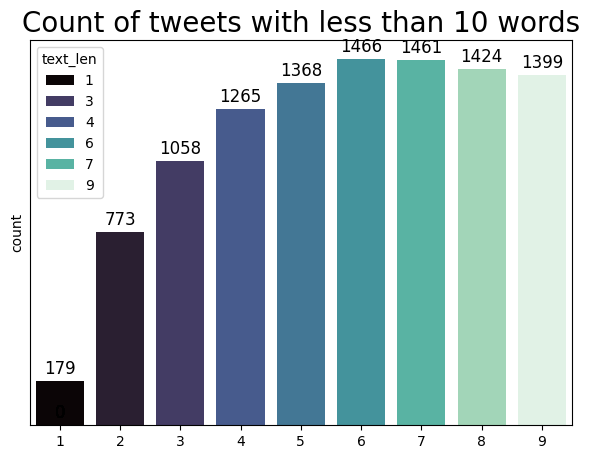

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.countplot(x='text_len', data=train[train['text_len'] < 10], hue='text_len', palette='mako', dodge=False)

plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
plt.ylabel('count')
plt.xlabel('')

# Tambahkan label pada setiap bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

In [ ]:
temp_train = train.sort_values(by=['text_len'], ascending=False)

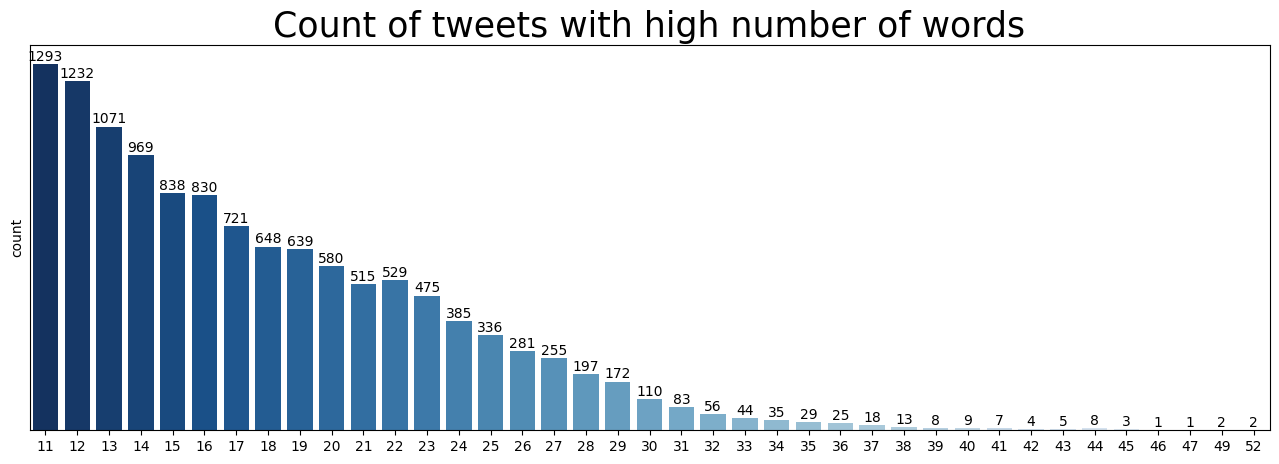

In [ ]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=temp_train[(temp_train['text_len']<=1000) & (temp_train['text_len']>10)], hue='text_len', palette='Blues_r', dodge=False, legend=False)
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
plt.ylabel('count')
plt.xlabel('')

# Menambahkan label pada setiap bar
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 0.5,
        int(p.get_height()),
        ha='center',
        va='bottom'
    )

plt.show()

In [ ]:
# Misalkan texts adalah list dari semua teks dalam dataset
texts = train.text_akhir.values
lengths = [len(text.split()) for text in texts]

In [ ]:
# Misalkan texts adalah list dari semua teks dalam dataset
all_words = ' '.join(texts).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20) # Mendapatkan 20 kata paling umum

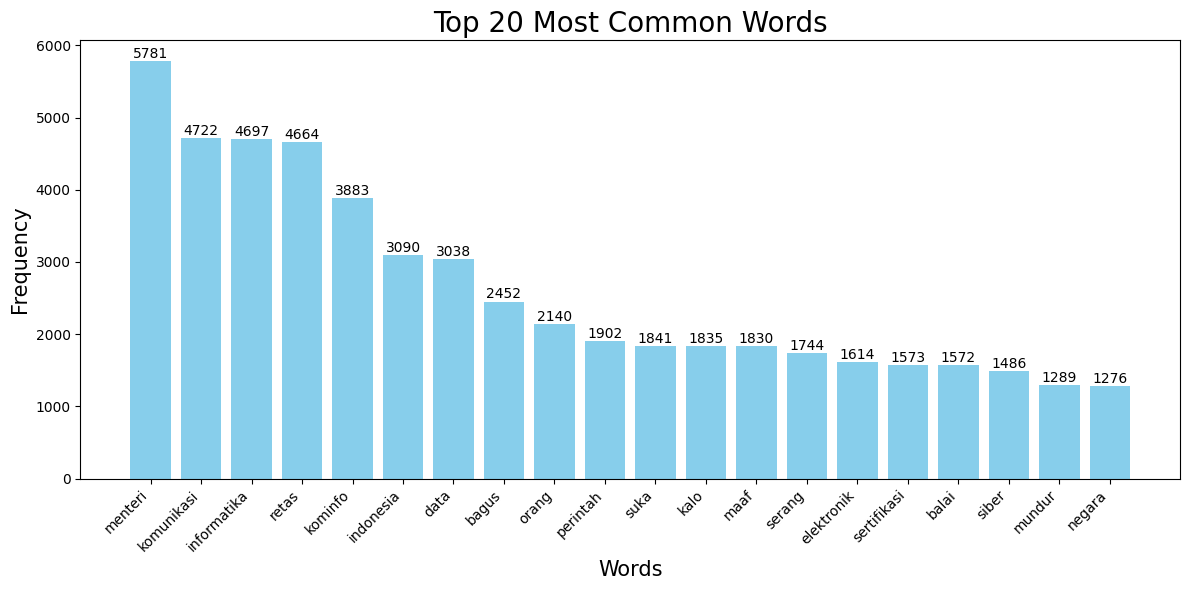

In [ ]:
# Memisahkan kata-kata dan frekuensinya untuk plot
words, frequencies = zip(*common_words)

# Membuat plot
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies, color='skyblue')
plt.title('Top 20 Most Common Words', fontsize=20)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Menambahkan label pada setiap batang
for i, freq in enumerate(frequencies):
    plt.text(i, freq + 0.5, str(freq), ha='center', va='bottom', fontsize=10)

plt.show()

In [ ]:
# Menghitung persentase teks yang berada di bawah panjang tertentu
max_len = max(lengths)

# Menghitung panjang maksimum
print(f"Max length: {max_len}")
below_max_len = np.sum(np.array(lengths) <= max_len) / len(lengths)

# Menghitung persentase teks yang panjangnya di bawah atau sama dengan max_len
print(f"{below_max_len * 100:.2f}% of texts are shorter than {max_len} words.")

Max length: 52
100.00% of texts are shorter than 52 words.


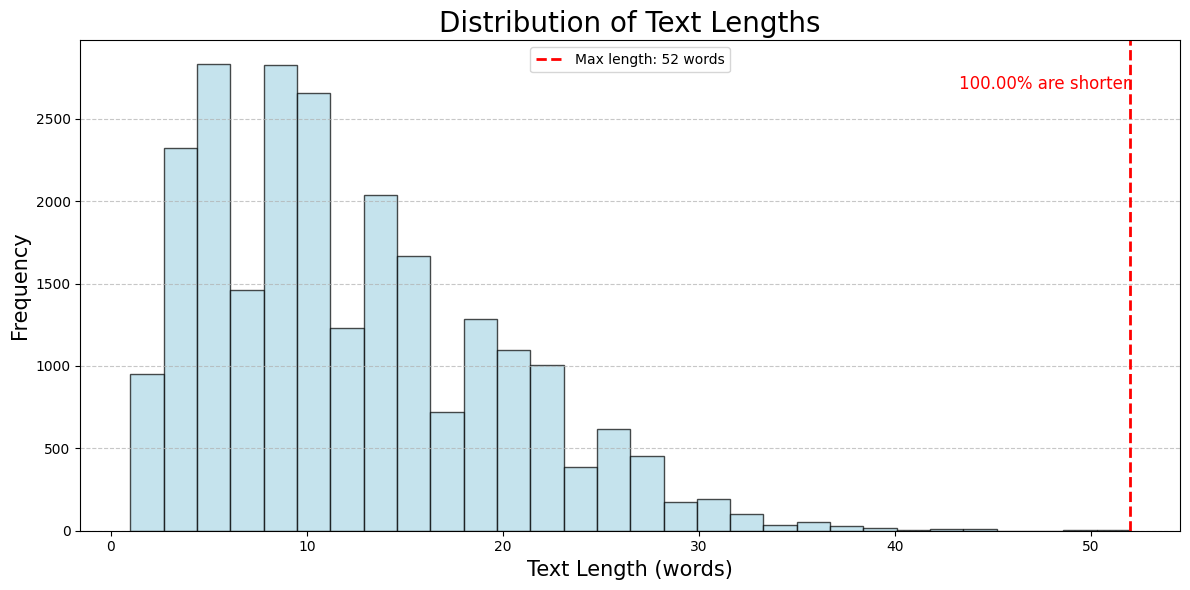

In [ ]:
# Membuat plot
plt.figure(figsize=(12, 6))
plt.hist(lengths, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
plt.axvline(max_len, color='red', linestyle='--', linewidth=2, label=f'Max length: {max_len} words')
plt.text(max_len, plt.ylim()[1] * 0.9, f'{below_max_len * 100:.2f}% are shorter', color='red', ha='right', fontsize=12)

plt.title('Distribution of Text Lengths', fontsize=20)
plt.xlabel('Text Length (words)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Check if GPU is available


In [ ]:
# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

## Handling Imbalanced Class

In [ ]:
train.label.value_counts()

label
neutral     11498
negative     7580
positive     5105
Name: count, dtype: int64

In [ ]:
neg = train[train["label"] == "negative"]
pos = train[train["label"] == "positive"]
neu = train[train["label"] == "neutral"]

In [ ]:
print(f' Total data hasil scraping Twitter adalah sebanyak {train.shape[0]} data', "\n")
print(f' Total data negative adalah sebanyak: {neg.shape[0]} data')
print(f' Total data neutral adalah sebanyak: {neu.shape[0]} data')
print(f' Total data positive adalah sebanyak: {pos.shape[0]} data')

 Total data hasil scraping Twitter adalah sebanyak 24183 data 

 Total data negative adalah sebanyak: 7580 data
 Total data neutral adalah sebanyak: 11498 data
 Total data positive adalah sebanyak: 5105 data


In [ ]:
'''Jadi karena data imbalanced, maka akan di balancing'''

'Jadi karena data imbalanced, maka akan di balancing'

In [ ]:
neu = neu.sort_values(by = "sentiment score", ascending = False).head(4250)
neg = neg.sort_values(by = "sentiment score", ascending = False).head(4250)
pos = pos.sort_values(by = "sentiment score", ascending = False).head(4250)

In [ ]:
train = pd.concat([neg, pos, neu], ignore_index=True)

In [ ]:
jumlah_test_data = int(np.ceil(train.shape[0] * 0.15))
jumlah_train_data = train.shape[0] - jumlah_test_data

# Cetak hasil
print(f"Jumlah data uji: {jumlah_test_data}")
print(f"Jumlah data pelatihan: {jumlah_train_data}")

Jumlah data uji: 1913
Jumlah data pelatihan: 10837


## Extract Data with BERT Transformers

In [ ]:
!pip install transformers
from transformers import BertModel, BertTokenizer
import torch

tokenizer = BertTokenizer.from_pretrained('mdhugol/indonesia-bert-sentiment-classification')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Minimum length: 3
Maximum length: 64
Mean length: 16.20870588235294
Median length: 14.0
90th percentile length: 29.0


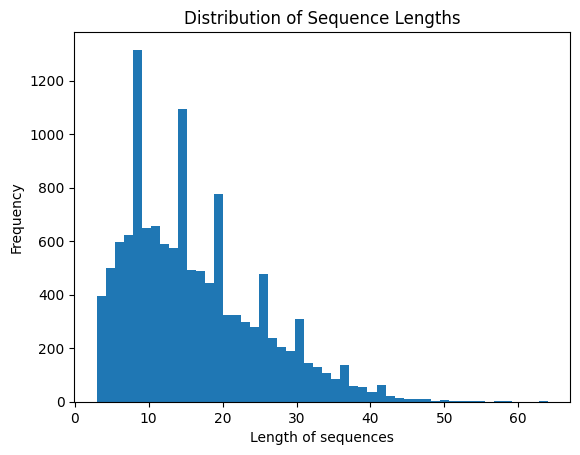

In [ ]:
# Misalkan 'train' adalah DataFrame yang berisi data
lengths = train['text_akhir'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))
lengths = np.array(lengths)

# Hitung statistik deskriptif
print(f"Minimum length: {np.min(lengths)}")
print(f"Maximum length: {np.max(lengths)}")
print(f"Mean length: {np.mean(lengths)}")
print(f"Median length: {np.median(lengths)}")
print(f"90th percentile length: {np.percentile(lengths, 90)}")

# Plot histogram untuk visualisasi
import matplotlib.pyplot as plt

plt.hist(lengths, bins=50)
plt.xlabel('Length of sequences')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [ ]:
# Load the pre-trained BERT model and tokenizer
model = BertModel.from_pretrained('mdhugol/indonesia-bert-sentiment-classification', output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('mdhugol/indonesia-bert-sentiment-classification')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Define a function to extract features for each transaction
def extract_features(text):
    # Tokenize the text
    input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
    # Get the hidden states for each token
    with torch.no_grad():
        outputs = model(input_ids)
        hidden_states = outputs[2]
    # Concatenate the last 4 hidden states
    token_vecs = []
    for layer in range(-4, 0):
        token_vecs.append(hidden_states[layer][0])
    # Calculate the mean of the last 4 hidden states
    features = []
    for token in token_vecs:
        features.append(torch.mean(token, dim=0))
    # Return the features as a tensor
    return torch.stack(features)

In [ ]:
# Extract features for each transaction
features = []
for i in range(len(train)):
    features.append(extract_features(train.iloc[i]["text_akhir"]))
# Concatenate the features and convert to a numpy array
features = torch.cat(features).numpy()

In [ ]:
features

array([[ 0.3755689 , -0.06602324,  0.12716529, ...,  0.83326817,
        -1.692582  , -0.40330908],
       [ 0.42541724,  0.13478225,  0.48638007, ...,  0.7742595 ,
        -2.1160605 , -0.24978529],
       [ 0.59465706,  0.2280338 ,  1.0263653 , ...,  0.58320737,
        -1.4966241 , -0.29138798],
       ...,
       [-0.2219699 , -0.9398893 ,  1.2294312 , ...,  0.12884477,
        -0.98098874,  0.09818135],
       [-0.19196199, -0.74700516,  1.6124247 , ..., -0.05780453,
        -0.59349734, -0.10028489],
       [ 0.19314638, -0.42263752,  1.3746259 , ..., -0.57999235,
         0.10886   ,  0.12552407]], dtype=float32)

In [ ]:
# # Save the features as a .npy file
# np.save(folder_path_all_data + "/Data After Labeling/[Untuk DL]train_bert_transformer_features.npy", features)

# load features from a .npy file
features = np.load(folder_path_all_data + "/Data After Labeling/[Untuk DL]train_bert_transformer_features.npy")

In [ ]:
labels = train['label'].values
labels

array(['negative', 'negative', 'negative', ..., 'neutral', 'neutral',
       'neutral'], dtype=object)

In [ ]:
print(features.shape)
print(labels.shape)

(51000, 768)
(12750,)


In [ ]:
# features is a 2D numpy array of size 51000x768
# labels is a 1D numpy array of size 12750
# reshape the feature array to size 12750(768*3)

features_reshaped = features.reshape((12750, -1))

# concatenate the feature array with the label array horizontally
dataset_bert_extraction = np.hstack((features_reshaped, labels.reshape((-1, 1))))

# dataset is a 2D numpy array of size 1000x(4000*768+1)

In [ ]:
display(features_reshaped.shape)
display(dataset_bert_extraction.shape)

(12750, 3072)

(12750, 3073)

## Splitting Dataset

In [ ]:
# Memisahkan fitur dan label
X_bert = dataset_bert_extraction[:, :-1]  # Semua kolom kecuali kolom terakhir
y_bert = dataset_bert_extraction[:, -1]   # Kolom terakhir sebagai label

# Membagi data dengan stratifikasi
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    X_bert, y_bert,
    test_size=0.1,
    random_state=7,
    stratify=y_bert
)

# Menggabungkan kembali fitur dan label menjadi satu array
bert_train_data = np.hstack((X_train_bert, y_train_bert.reshape(-1, 1)))
bert_test_data = np.hstack((X_test_bert, y_test_bert.reshape(-1, 1)))

In [ ]:
bert_train_data.shape, bert_test_data.shape

((11475, 3073), (1275, 3073))

In [ ]:
Counter(y_train_bert), Counter(y_test_bert)

(Counter({'negative': 3825, 'neutral': 3825, 'positive': 3825}),
 Counter({'positive': 425, 'negative': 425, 'neutral': 425}))

### Make it a dataframe

In [ ]:
# Membuat nama kolom
num_features = 3072  # Jumlah fitur
feature_columns = [f'feature_{i+1}' for i in range(num_features)]  # Membuat nama fitur dari feature1 hingga feature3072
columns = feature_columns + ['label']  # Menambahkan kolom 'label' di akhir

In [ ]:
# Membuat DataFrame dari bert_train_data
df_bert_train = pd.DataFrame(bert_train_data, columns=columns)
# Membuat DataFrame dari bert_test_data
df_bert_test = pd.DataFrame(bert_test_data, columns=columns)

In [ ]:
df_bert_train.shape, df_bert_test.shape

((11475, 3073), (1275, 3073))

### Split X and y (Test, Train)

In [ ]:
# Memisahkan fitur dan label
X_train = df_bert_train.iloc[:, :-1].values  # Semua kolom kecuali kolom terakhir
y_train = df_bert_train.iloc[:, -1].values   # Kolom terakhir adalah label

X_test = df_bert_test.iloc[:, :-1].values
y_test = df_bert_test.iloc[:, -1].values

## Encoding Label

In [ ]:
# Change Target to One Hot Encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encoding labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-Hot Encoding labels
y_train_ohe = to_categorical(y_train_encoded, num_classes=3)
y_test_ohe = to_categorical(y_test_encoded, num_classes=3)

In [ ]:
# Munculkan panduan label setelah encoding
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print("Panduan Label setelah Encoding:")
for key, value in label_mapping.items():
    print(f"Encoded {key} untuk label {value}")

Panduan Label setelah Encoding:
Encoded 0 untuk label negative
Encoded 1 untuk label neutral
Encoded 2 untuk label positive


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# Menormalkan data fitur
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Mengubah bentuk data untuk LSTM
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

## Define Class Weight for Model

In [ ]:
# Menghitung class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_test_encoded)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print('Class Weights:', class_weights_dict)

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0}


## Define Callbacks

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint, ReduceLROnPlateau

# ReduceLROnPlateau untuk menurunkan learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.2,
    patience=3,
    min_lr=0.000001,
    verbose=2
)

# Tentukan kondisi EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor akurasi pada data validasi
    patience=4,  # Toleransi untuk tidak ada peningkatan
    restore_best_weights=True,  # Kembalikan bobot terbaik ketika berhenti
    verbose=2
)

## Create Model

### Multi-Layer LSTM

In [ ]:
# Definisikan model LSTM
model_LSTM = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(units=3, activation='softmax')  # Gunakan softmax untuk multi-kelas
])

# Compile model
model_LSTM.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [ ]:
# Bangun model dengan input shape yang sudah ditentukan
model_LSTM.build((None, X_train_scaled.shape[1], X_train_scaled.shape[2]))

model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 1, 256)            3277824   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 256)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 1

## Training Model

In [ ]:
import time
start_time = time.time() # Measure training time

# Training model
history_lstm = model_LSTM.fit(X_train_scaled, y_train_ohe, verbose=2, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_ohe), class_weight=class_weights_dict, callbacks=[early_stopping, reduce_lr])

duration = time.time() - start_time
minutes = duration / 60
hours = duration / 3600

Epoch 1/50
359/359 - 31s - loss: 0.2271 - accuracy: 0.9455 - val_loss: 0.0521 - val_accuracy: 0.9867 - lr: 1.0000e-04 - 31s/epoch - 87ms/step
Epoch 2/50
359/359 - 18s - loss: 0.0699 - accuracy: 0.9837 - val_loss: 0.0558 - val_accuracy: 0.9867 - lr: 1.0000e-04 - 18s/epoch - 51ms/step
Epoch 3/50
359/359 - 18s - loss: 0.0653 - accuracy: 0.9847 - val_loss: 0.0450 - val_accuracy: 0.9882 - lr: 1.0000e-04 - 18s/epoch - 51ms/step
Epoch 4/50
359/359 - 17s - loss: 0.0617 - accuracy: 0.9862 - val_loss: 0.0523 - val_accuracy: 0.9867 - lr: 1.0000e-04 - 17s/epoch - 46ms/step
Epoch 5/50
359/359 - 17s - loss: 0.0608 - accuracy: 0.9853 - val_loss: 0.0436 - val_accuracy: 0.9882 - lr: 1.0000e-04 - 17s/epoch - 47ms/step
Epoch 6/50

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
359/359 - 17s - loss: 0.0552 - accuracy: 0.9863 - val_loss: 0.0513 - val_accuracy: 0.9859 - lr: 1.0000e-04 - 17s/epoch - 47ms/step
Epoch 7/50
Restoring model weights from the end of the best epoch: 3.


In [ ]:
print(f"--- Waktu training adalah {duration} detik ---")
print(f"--- Waktu training adalah {minutes} menit ---")
print(f"--- Waktu training adalah {hours} jam ---")

--- Waktu training adalah 135.7965784072876 detik ---
--- Waktu training adalah 2.2632763067881267 menit ---
--- Waktu training adalah 0.03772127177980211 jam ---


## Evaluasi model


In [ ]:
# Evaluasi model
y_test_pred = model_LSTM.predict(X_test_scaled)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
print('Test Classification Report:')
print(classification_report(y_test_encoded, y_test_pred_classes))
print('Test Confusion Matrix:')
print(confusion_matrix(y_test_encoded, y_test_pred_classes))

40/40 [==============================] - 6s 36ms/step
Test Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       425
           1       0.99      0.99      0.99       425
           2       1.00      0.98      0.99       425

    accuracy                           0.99      1275
   macro avg       0.99      0.99      0.99      1275
weighted avg       0.99      0.99      0.99      1275

Test Confusion Matrix:
[[420   3   2]
 [  3 422   0]
 [  4   3 418]]


In [ ]:
# Hitung Balanced Accuracy Score
test_balanced_accuracy = balanced_accuracy_score(y_test_encoded, y_test_pred_classes)
print('Test Balanced Accuracy Score:', test_balanced_accuracy)

Test Balanced Accuracy Score: 0.9882352941176471


In [ ]:
# Evaluasi model pada data uji
test_loss, test_accuracy = model_LSTM.evaluate(X_test_scaled, y_test_ohe)

print('Test Accuracy:', test_accuracy)

40/40 [==============================] - 1s 27ms/step - loss: 0.0450 - accuracy: 0.9882
Test Accuracy: 0.9882352948188782


In [ ]:
def plot_learning_curves(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history_lstm.history[arr[idx][0]])
        ax[idx].plot(history_lstm.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('Epoch ',fontsize=16)
        ax[idx].set_ylabel('Acc or lost',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

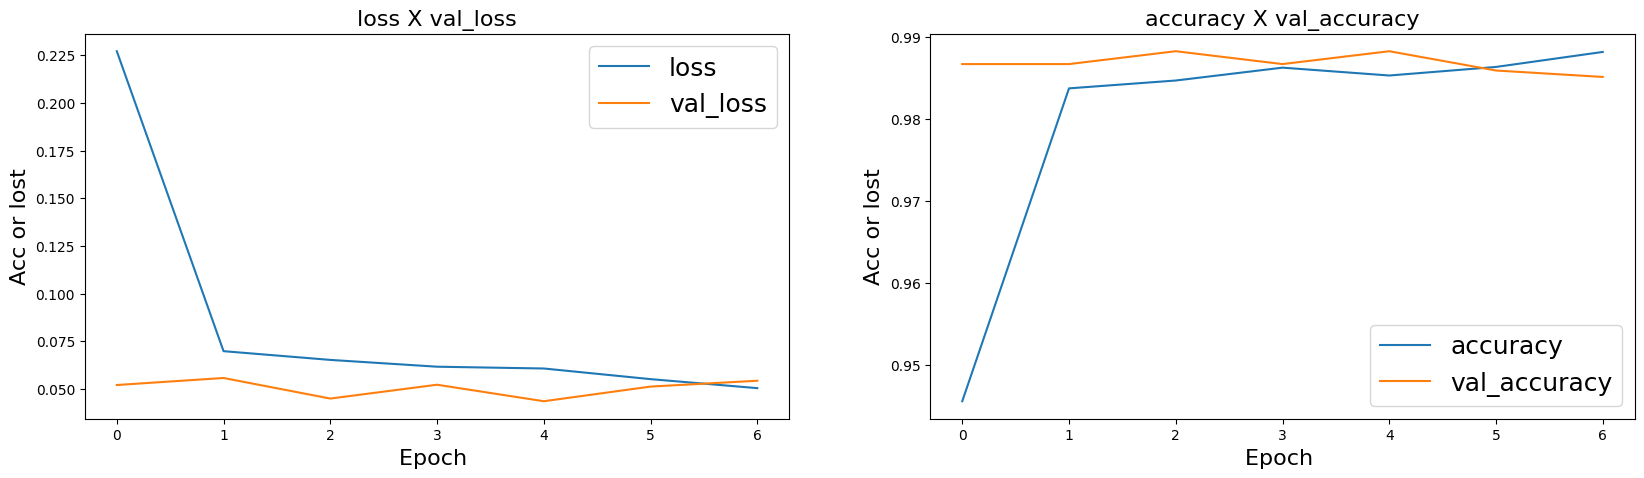

In [ ]:
plot_learning_curves(history_lstm, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

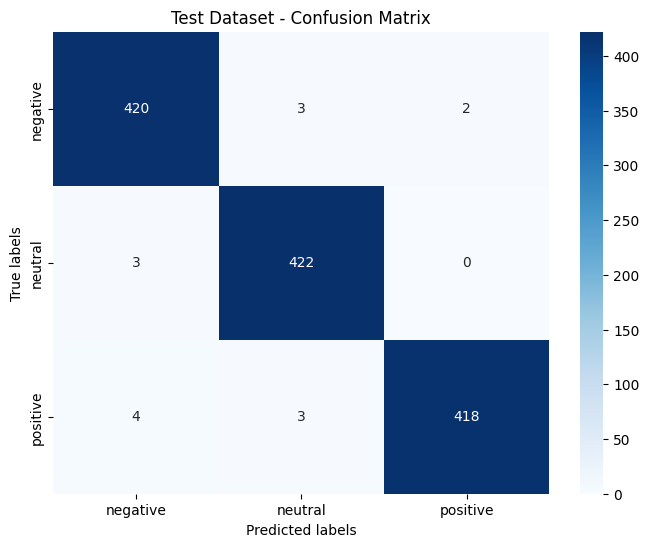

In [ ]:
# Hitung confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test_ohe, axis=1), y_test_pred_classes)

# Plot confusion matrix menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'neutral', 'positive'],
            yticklabels=['negative', 'neutral', 'positive'])

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Test Dataset - Confusion Matrix')
plt.show()

## Saving Model and Prove 92% ++ Test ACC

In [ ]:
# Menyimpan model ke file
model_LSTM.save(folder_path_all_data + "/Trained Model/2. model_LSTM_[0.9882352941176471].h5")

# Format TensorFlow SavedModel
model_LSTM.save(folder_path_all_data + "/Trained Model/2. model_LSTM_[0.9882352941176471]")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Load the model in HDF5 format
model_LSTM_loaded1 = load_model(folder_path_all_data + "/Trained Model/2. model_LSTM_[0.9882352941176471].h5")

In [ ]:
# Misalkan kita punya data input baru dalam variabel X_new_scaled
predictions = model_LSTM_loaded1.predict(X_test_scaled)
predicted_classes = np.argmax(predictions, axis=1)

40/40 [==============================] - 3s 15ms/step


In [ ]:
# Hitung Balanced Accuracy Score
test_accuracy = accuracy_score(y_test_encoded, predicted_classes)
print('Test Accuracy Score:', test_accuracy)

Test Accuracy Score: 0.9882352941176471


## ***Model Inference***
---

In [ ]:
test = pd.read_csv(folder_path_all_data + "/Data After Labeling/test model inference [After Processing].csv")

### BERT Feature Extraction

In [ ]:
!pip install transformers
from transformers import BertModel, BertTokenizer
import torch

In [ ]:
# Load the pre-trained BERT model and tokenizer
model = BertModel.from_pretrained('mdhugol/indonesia-bert-sentiment-classification', output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained('mdhugol/indonesia-bert-sentiment-classification')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# Define a function to extract features for each transaction
def extract_features(text):
    # Tokenize the text
    input_ids = torch.tensor([tokenizer.encode(text, add_special_tokens=True)])
    # Get the hidden states for each token
    with torch.no_grad():
        outputs = model(input_ids)
        hidden_states = outputs[2]
    # Concatenate the last 4 hidden states
    token_vecs = []
    for layer in range(-4, 0):
        token_vecs.append(hidden_states[layer][0])
    # Calculate the mean of the last 4 hidden states
    features = []
    for token in token_vecs:
        features.append(torch.mean(token, dim=0))
    # Return the features as a tensor
    return torch.stack(features)

In [ ]:
# Extract features for each transaction
features = []
for i in range(len(test)):
    features.append(extract_features(test.iloc[i]["text_akhir"]))
# Concatenate the features and convert to a numpy array
features = torch.cat(features).numpy()

In [ ]:
labels = test['label'].values
labels

array(['neutral', 'neutral', 'neutral', ..., 'positive', 'neutral',
       'negative'], dtype=object)

In [ ]:
print(features.shape)
print(labels.shape)

(10756, 768)
(2689,)


### Adjust the data for predict

In [ ]:
# features is a 2D numpy array of size 10756
# labels is a 1D numpy array of size 2689
# reshape the feature array to size 2689(768*3)

features_reshaped = features.reshape((2689, -1))

# concatenate the feature array with the label array horizontally
test_bert_extraction = np.hstack((features_reshaped, labels.reshape((-1, 1))))

In [ ]:
# Memisahkan fitur dan label
X_test_bert = test_bert_extraction[:, :-1]  # Semua kolom kecuali kolom terakhir
y_test_bert = test_bert_extraction[:, -1]   # Kolom terakhir sebagai label

# Menggabungkan kembali fitur dan label menjadi satu array
bert_test_data = np.hstack((X_test_bert, y_test_bert.reshape(-1, 1)))

In [ ]:
bert_test_data.shape

(2689, 3073)

In [ ]:
# Membuat nama kolom
num_features = 3072  # Jumlah fitur
feature_columns = [f'feature_{i+1}' for i in range(num_features)]  # Membuat nama fitur dari feature1 hingga feature3072
columns = feature_columns + ['label']  # Menambahkan kolom 'label' di akhir

In [ ]:
# Membuat DataFrame dari bert_test_data
df_bert_test = pd.DataFrame(bert_test_data, columns=columns)

In [ ]:
df_bert_test.shape

(2689, 3073)

In [ ]:
# Memisahkan fitur dan label
X_test = df_bert_test.iloc[:, :-1].values # Semua kolom kecuali kolom terakhir
y_test = df_bert_test.iloc[:, -1].values # Kolom terakhir adalah label

### Label Encoder

In [ ]:
# Change Target to One Hot Encoding
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encoding labels
label_encoder = LabelEncoder()

y_test_encoded = label_encoder.fit_transform(y_test)
y_test_ohe = to_categorical(y_test_encoded, num_classes=3)

In [ ]:
# Munculkan panduan label setelah encoding
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print("Panduan Label setelah Encoding:")
for key, value in label_mapping.items():
    print(f"Encoded {key} untuk label {value}")

Panduan Label setelah Encoding:
Encoded 0 untuk label negative
Encoded 1 untuk label neutral
Encoded 2 untuk label positive


### MinMaxScaler

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

# Menormalkan data fitur
X_test_scaled = scaler.fit_transform(X_test)

# Mengubah bentuk data untuk LSTM
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

### Load Model & *Predict*

In [ ]:
from tensorflow.keras.models import load_model

# Load the model in HDF5 format
model_LSTM_loaded = load_model(folder_path_all_data + "/Trained Model/2. model_LSTM_[0.9882352941176471].h5")

In [ ]:
# Misalkan kita punya data input baru dalam variabel X_new_scaled
predictions = model_LSTM_loaded.predict(X_test_scaled)
predicted_classes = np.argmax(predictions, axis=1)

85/85 [==============================] - 2s 5ms/step


In [ ]:
# Hitung Balanced Accuracy Score
test_accuracy = accuracy_score(y_test_encoded, predicted_classes)
print('Test Accuracy Score:', test_accuracy)

Test Accuracy Score: 0.8300483451097063


# ***SKENARIO - 3***
---

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, get_scheduler, AutoModelForSequenceClassification, AdamW
from tqdm.auto import tqdm

from sklearn.metrics import (
    precision_score, # Precision score - Metric for evaluating classification models, measuring the ratio of correctly predicted positive observations to the total predicted positives.
    recall_score, # Recall score - Metric for evaluating classification models, measuring the ratio of correctly predicted positive observations to the total actual positives.
    f1_score, # F1 score - Harmonic mean of precision and recall, a metric for evaluating classification models.
    classification_report, # Classification report - Summary of the precision, recall, F1 score, and support for each class in a classification problem.
    accuracy_score, # Accuracy score - Metric for evaluating classification models, measuring the proportion of correct predictions to the total number of predictions.
    balanced_accuracy_score
)

## Loading Data & Balancing Class

In [ ]:
mainPath = "/content/drive/MyDrive/Colab Notebooks/9. DBS Foundation x Dicoding Kelas Menengah 2024"
folder_path_all_data = "/content/drive/MyDrive/Colab Notebooks/9. DBS Foundation x Dicoding Kelas Menengah 2024/Start Dari 0 Lagi"

additionalPath = os.path.join(mainPath, "Additional Data")
modelPath = folder_path_all_data + "/Trained Model/"

In [ ]:
train = pd.read_csv(folder_path_all_data + "/Data After Labeling/train_after_processing.csv")
train.isnull().sum()
train = train.dropna(subset = "text_akhir")

In [ ]:
train.label.value_counts()

label
neutral     11498
negative     7580
positive     5105
Name: count, dtype: int64

In [ ]:
neg = train[train["label"] == "negative"]
pos = train[train["label"] == "positive"]
neu = train[train["label"] == "neutral"]

In [ ]:
neu = neu.sort_values(by = "sentiment score", ascending = False).head(4250)
neg = neg.sort_values(by = "sentiment score", ascending = False).head(4250)
pos = pos.sort_values(by = "sentiment score", ascending = False).head(4250)

In [ ]:
train = pd.concat([neg, pos, neu], ignore_index=True)

## Splitting Data

In [ ]:
# Memecah data menjadi 80% dan 20% test
X_train, X_test, y_train, y_test = train_test_split(train.text_akhir,
                                                            train.label,
                                                            test_size=0.10,
                                                            random_state=42,
                                                            stratify=train.label)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (11475,)
Test Size  :  (1275,)


In [ ]:
y_train.value_counts(), y_test.value_counts()

(label
 positive    3825
 neutral     3825
 negative    3825
 Name: count, dtype: int64,
 label
 neutral     425
 positive    425
 negative    425
 Name: count, dtype: int64)

## Encoding Label

In [ ]:
# Encode labels as integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert to pandas Series if necessary
if not isinstance(y_train_encoded, pd.Series):
    y_train_encoded = pd.Series(y_train_encoded)
    y_test_encoded = pd.Series(y_test_encoded)

In [ ]:
# Munculkan panduan label setelah encoding
label_mapping = dict(zip(range(len(label_encoder.classes_)), label_encoder.classes_))
print("Panduan Label setelah Encoding:")
for key, value in label_mapping.items():
    print(f"Encoded {key} untuk label {value}")

Panduan Label setelah Encoding:
Encoded 0 untuk label negative
Encoded 1 untuk label neutral
Encoded 2 untuk label positive


## Indobertweet Embedding - Finetune [***Without Class Weight***]

In [ ]:
num_labels = len(label_encoder.classes_)

In [ ]:
# Define the Dataset class
class YourDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels.astype(int)  # Ensure labels are integers
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# List of model names
model_names = [
    "mdhugol/indonesia-bert-sentiment-classification",
]

# Load the tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 32
num_epochs = 5

# Define the evaluation function
def evaluate(model, dataloader):
    model.eval()
    total_eval_loss = 0
    total_eval_accuracy = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        preds = torch.argmax(logits, dim=-1)
        accuracy = (preds == labels).float().mean()
        total_eval_accuracy += accuracy.item()

    avg_loss = total_eval_loss / len(dataloader)
    avg_accuracy = total_eval_accuracy / len(dataloader)
    return avg_loss, avg_accuracy

# Predict function
def predict(texts, tokenizer, model, max_length=128):
    texts = [str(text) for text in texts]
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)
    return preds

# Evaluation function
def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    report = classification_report(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "report": report,
        "accuracy": accuracy,
        "balanced_accuracy": balanced_accuracy
    }

# Storage for models and results
trained_models = {}
evaluation_results = {}

# Loop through each model name
for model_name in model_names:
    print(f"Finetuning {model_name}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    model.to(device)

    # Create datasets and dataloaders
    train_dataset = YourDataset(X_train, y_train_encoded, tokenizer)
    test_dataset = YourDataset(X_test, y_test_encoded, tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    # Define optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=5e-5)
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_train_accuracy = 0

        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_train_loss += loss.item()

            preds = torch.argmax(logits, dim=-1)
            accuracy = (preds == labels).float().mean()
            total_train_accuracy += accuracy.item()

            loss.backward()
            optimizer.step()
            lr_scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)
        avg_train_accuracy = total_train_accuracy / len(train_dataloader)

        test_loss, test_accuracy = evaluate(model, test_dataloader)

        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

    print("Training Completed")

    # Predict on the test set
    texts_to_predict = X_test.tolist()
    predictions = predict(texts_to_predict, tokenizer, model)
    decoded_predictions = label_encoder.inverse_transform(predictions.cpu().numpy())

    # Evaluate the model
    evaluation = evaluate_model(y_test, decoded_predictions)

    # Save the model and results
    trained_models[model_name] = model
    evaluation_results[model_name] = evaluation

    # Print evaluation metrics
    print(f"Evaluation for {model_name}")
    print("Precision Score: ", evaluation["precision"])
    print("Recall Score: ", evaluation["recall"])
    print("F1 Score: ", evaluation["f1"])
    print("\nClassification Report:")
    print(evaluation["report"])
    print("Accuracy Score: ", evaluation["accuracy"])
    print("Balanced Accuracy Score: ", evaluation["balanced_accuracy"])

print("All models have been trained and evaluated.")

Finetuning mdhugol/indonesia-bert-sentiment-classification


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch 1/5
Train Loss: 0.2159 | Train Accuracy: 0.9219
Test Loss: 0.1016 | Test Accuracy: 0.9600


Epoch 2/5:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch 2/5
Train Loss: 0.0668 | Train Accuracy: 0.9785
Test Loss: 0.0855 | Test Accuracy: 0.9672


Epoch 3/5:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch 3/5
Train Loss: 0.0254 | Train Accuracy: 0.9906
Test Loss: 0.1446 | Test Accuracy: 0.9553


Epoch 4/5:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch 4/5
Train Loss: 0.0103 | Train Accuracy: 0.9970
Test Loss: 0.1380 | Test Accuracy: 0.9647


Epoch 5/5:   0%|          | 0/359 [00:00<?, ?it/s]

Epoch 5/5
Train Loss: 0.0043 | Train Accuracy: 0.9990
Test Loss: 0.1195 | Test Accuracy: 0.9664
Training Completed
Evaluation for mdhugol/indonesia-bert-sentiment-classification
Precision Score:  0.9664249389501681
Recall Score:  0.9662745098039216
F1 Score:  0.9662350997653313

Classification Report:
              precision    recall  f1-score   support

    negative       0.98      0.95      0.96       425
     neutral       0.97      0.99      0.98       425
    positive       0.95      0.97      0.96       425

    accuracy                           0.97      1275
   macro avg       0.97      0.97      0.97      1275
weighted avg       0.97      0.97      0.97      1275

Accuracy Score:  0.9662745098039216
Balanced Accuracy Score:  0.9662745098039215
All models have been trained and evaluated.


## Saving Model and Prove 92% ++ Test ACC

In [ ]:
modelPath

'/content/drive/MyDrive/Colab Notebooks/9. DBS Foundation x Dicoding Kelas Menengah 2024/Start Dari 0 Lagi/Trained Model/'

In [ ]:
model.save_pretrained(modelPath + "3. [Model and Tokenizer] mdhugol - indonesia-bert-sentiment-classification_[0.9662745098039216]") # Lulus Persyaratannya
tokenizer.save_pretrained(modelPath + "3. [Model and Tokenizer] mdhugol - indonesia-bert-sentiment-classification_[0.9662745098039216]") # Lulus Persyaratannya

('/content/drive/MyDrive/Colab Notebooks/9. DBS Foundation x Dicoding Kelas Menengah 2024/Start Dari 0 Lagi/Trained Model/3. [tokenizer] mdhugol - indonesia-bert-sentiment-classification_[0.9662745098039216]/tokenizer_config.json',
 '/content/drive/MyDrive/Colab Notebooks/9. DBS Foundation x Dicoding Kelas Menengah 2024/Start Dari 0 Lagi/Trained Model/3. [tokenizer] mdhugol - indonesia-bert-sentiment-classification_[0.9662745098039216]/special_tokens_map.json',
 '/content/drive/MyDrive/Colab Notebooks/9. DBS Foundation x Dicoding Kelas Menengah 2024/Start Dari 0 Lagi/Trained Model/3. [tokenizer] mdhugol - indonesia-bert-sentiment-classification_[0.9662745098039216]/vocab.txt',
 '/content/drive/MyDrive/Colab Notebooks/9. DBS Foundation x Dicoding Kelas Menengah 2024/Start Dari 0 Lagi/Trained Model/3. [tokenizer] mdhugol - indonesia-bert-sentiment-classification_[0.9662745098039216]/added_tokens.json',
 '/content/drive/MyDrive/Colab Notebooks/9. DBS Foundation x Dicoding Kelas Menengah 2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = os.path.join(modelPath, "3. [Model and Tokenizer] mdhugol - indonesia-bert-sentiment-classification_[0.9662745098039216]")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Fungsi untuk melakukan prediksi
def predict(texts, tokenizer, model, max_length=128):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)
    return preds

In [ ]:
y_pred_indices = predict(X_test.tolist(), tokenizer, model).cpu().numpy() # udah run tpi lama, jadi ku copy aja hasil output nya taruh di cell bawah
# Mengubah indeks kelas menjadi label asli
y_pred_labels = label_encoder.inverse_transform(y_pred_indices)

In [ ]:
Counter(y_pred_labels)

Counter({'neutral': 431, 'positive': 432, 'negative': 412})

In [ ]:
# Evaluasi akurasi model
accuracy = accuracy_score(y_test, y_pred_labels)

In [ ]:
accuracy # Akurasi for model Inference

0.9662745098039216

## ***Model Inference***
---

In [ ]:
test = pd.read_csv(folder_path_all_data + "/Data After Labeling/test model inference [After Processing].csv")

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
from transformers import AutoModelForSequenceClassification, AdamW, get_scheduler, AutoTokenizer
from tqdm.auto import tqdm
from sklearn.metrics import balanced_accuracy_score

### Load Model and Tokenizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = os.path.join(modelPath, "3. [Model and Tokenizer] mdhugol - indonesia-bert-sentiment-classification_[0.9662745098039216]")
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### Make a Predict Funtion

In [ ]:
# Fungsi untuk melakukan prediksi
def predict(texts, tokenizer, model, max_length=128):
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)
    return preds

In [ ]:
X_test = test["text_akhir"].tolist()
y_test = test['label'].tolist()

### Prediction the unseen data

In [ ]:
y_pred_indices = predict(X_test, tokenizer, model).cpu().numpy() # udah run tpi lama, jadi ku copy aja hasil output nya taruh di cell bawah

# Panduan Label setelah Encoding
label_mapping = {
    0: 'negative',
    1: 'neutral',
    2: 'positive'
}

# Replace numerical labels with text labels
y_pred_labels = [label_mapping[idx] for idx in y_pred_indices]

In [ ]:
Counter(y_pred_labels)

Counter({'neutral': 1079, 'positive': 728, 'negative': 882})

In [ ]:
# Evaluasi akurasi model
accuracy = accuracy_score(y_test, y_pred_labels)

In [ ]:
accuracy # Akurasi for model Inference

0.8386017106731127

# Generate a requirements.txt file

In [ ]:
!pip freeze > requirements.txt